In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import photutils
import datetime
from datetime import datetime, timedelta
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)


import astropy
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry
from astropy.stats import sigma_clipped_stats
from astropy.table import Column
import glob 
import time
import astroalign as aa
import juliandate as jd

In [2]:
#Sets up df where data from different dates / filters can be stored
RV_Uma_df = pd.DataFrame(columns = ['File ID', 'x-pos', 'y-pos', 'Aperture Sum', 'Median Flux without bkg', 'Sum without bkg', 'Date and Time'])
StandardStar_df = pd.DataFrame(columns = ['File ID', 'x-pos', 'y-pos', 'Aperture Sum', 'Median Flux without bkg', 'Sum without bkg', 'Date and Time'])
RV_Uma_missed = []
StandardStar_missed = []

def GetData(filepath):
    
    #resets current image list
    image_list = []
    n = 0
    
    #Gets files in the filepath
    for file in glob.glob(filepath+"*.fits"):
        image_list.append(file)
        n=n+1
    #print("\n".join(image_list)) #Check all files have been found
    
    #Loops 
    for file in image_list:
        #Get the file
        image_file = get_pkg_data_filename(file)
        image_data = fits.getdata(image_file, ext=0)
    
        #Find file data
        fitsFile = fits.open(file)
        date_obs = fitsFile[0].header['DATE-OBS']
        filename = (file.replace(filepath,""))
        time = date_obs[11:19]
        date = date_obs[:10]
        data = fitsFile[0].data
        median = np.median(data)
    
        #setting up starfinder
        tol = 5*median
        fwhm = 10
        FindStars = DAOStarFinder(tol, fwhm)
    
        #finds the stars
        stars = FindStars(data)
    
        #loops through positions of stars and adds values to an array
        positions = []
        
        RV_Uma_added = False
        StandardStar_added = False
        
        for i in range(len(stars)):
            posn = (stars['xcentroid'][i], stars['ycentroid'][i])
            positions.append(posn)
        
            #Aperture and annulus set up
            aperture = CircularAperture((positions[i][0], positions[i][1]), r=3.5*fwhm)
            annulus = CircularAnnulus((positions[i][0], positions[i][1]), r_in=3.5*fwhm, r_out=(3.5*fwhm*np.sqrt(5)))
            aperstats = aperture_photometry(image_data, aperture)
            annulstats =  aperture_photometry(image_data, annulus)

            #Annulus set up and getting data
            annulus_masks = annulus.to_mask(method='center')
            annulus_data = annulus_masks.multiply(image_data)
            annulus_data_1d = annulus_data[annulus_masks.data > 0]
            median_bg = np.median(annulus_data_1d)
        
            #Apature data and set up
            aperture_masks = aperture.to_mask(method='center')
            aperture_data = aperture_masks.multiply(image_data)
            aperture_data_1d = aperture_data[aperture_masks.data > 0]
            
            #Calculations bkg sub etc
            flux = aperstats['aperture_sum'][0] - median_bg * aperture.area
            median_flux_bgsub = np.median(aperture_data_1d) - median_bg
            aperture_stats = ApertureStats(image_data, aperture)
            
            #Takes location of RV Uma and adds the data for it to the data frame 
            if ((1050 < stars['xcentroid'][i] < 1250) & ( 750 < stars['ycentroid'][i] < 1000)):
                RV_Uma_df.loc[len(RV_Uma_df)] = {'File ID': file,'x-pos': positions[i][0], 'y-pos': positions[i][1], 'Aperture Sum': aperstats['aperture_sum'][0], 'Median Flux without bkg': median_flux_bgsub, 'Sum without bkg':flux, 'Date and Time': date+" "+time}
                RV_Uma_added = True
            
            #Bit below is to selected TYC 3850-738-1
            elif ((250 < stars['xcentroid'][i] < 400) & ( 450 < stars['ycentroid'][i] < 600)):
                StandardStar_df.loc[len(StandardStar_df)] = {'File ID': file, 'x-pos': positions[i][0], 'y-pos': positions[i][1], 'Aperture Sum': aperstats['aperture_sum'][0], 'Median Flux without bkg': median_flux_bgsub, 'Sum without bkg':flux, 'Date and Time': date+" "+time}         
                StandardStar_added = True
        
        #adds file to missed list if the star counldn't be found
        if (RV_Uma_added == False):
            RV_Uma_missed.append(file)
        if(StandardStar_added == False):
            StandardStar_missed.append(file)
       
        print(file) #just to show progress
    
    print("\n",filepath, " has been added",)

In [3]:
GetData("..\\RV Uma\\2022_03_20\\Green\\")
GetData("..\\RV Uma\\2022_03_22\\Green\\")
GetData("..\\RV Uma\\2022_03_24\\Green\\")
GetData("..\\RV Uma\\2023_02_23\\RV_UMa\\Light\\Green\\")
GetData("..\\RV Uma\\2023_04_03\\RV_UMa\\Light\\Green\\")

..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_001.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_002.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_003.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_004.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_005.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_006.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_007.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_008.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_009.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_010.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_011.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_012.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_013.fits
..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Light_Green_32_secs_014.fits
..\RV 

..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_001.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_002.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_003.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_004.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_005.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_006.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_007.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_008.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_009.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_010.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_011.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_012.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_013.fits
..\RV Uma\2022_03_24\Green\Reduced_RV_Uma_Light_Green_32_secs_014.fits
..\RV 

..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduced_RV_Uma_Light_Green_60_secs_014.fits

 ..\RV Uma\2023_04_03\RV_UMa\Light\Green\  has been added


In [4]:
#print("Where RV_UMa is missing: ", RV_Uma_missed)
#print("Where Standard Star is missing: ", StandardStar_missed)

#removes Standard stars data where RV_Uma is missing and vise versa
for i in range (len(RV_Uma_missed)):
    StandardStar_df.drop(StandardStar_df.index[(StandardStar_df['File ID'] == RV_Uma_missed[i])], axis=0,inplace=True)

for i in range (len(StandardStar_missed)):
    RV_Uma_df.drop(RV_Uma_df.index[(RV_Uma_df['File ID'] == StandardStar_missed[i])], axis=0, inplace=True)
    
#Resets the index so it can loop and match up with eachother correctly
RV_Uma_df = RV_Uma_df.reset_index(drop=True) #The drop stops the old index from being added as a new column
StandardStar_df = StandardStar_df.reset_index(drop=True)

In [5]:
#Finding the mean of the standard star sum
StandardStarMean = StandardStar_df['Sum without bkg'].mean()

#finding the differeance between the points and it's average
StandardStar_df['Dif'] = StandardStarMean - StandardStar_df['Sum without bkg']

#Move all the standard star points so they are on the same line by correction
StandardStar_df['Corrected Sum'] = StandardStar_df['Sum without bkg'] + StandardStar_df['Dif']
RV_Uma_df['Corrected Sum'] = RV_Uma_df['Sum without bkg'] + StandardStar_df['Dif']

#Caculating instrumental mag
RV_Uma_df['Instrumental Magnitude'] = -2.5*np.log10(RV_Uma_df['Corrected Sum'])
StandardStar_df['Instrumental Magnitude'] = -2.5*np.log10(StandardStar_df['Corrected Sum'])

In [6]:
StandardStar_df
StandardStar_mean = np.mean(StandardStar_df['Corrected Sum'])
StandardStar_mean

1426.9670331723155

In [7]:
RV_Uma_df
RV_Uma_mean = np.mean(RV_Uma_df['Corrected Sum'])
RV_Uma_mean

2964.68014390216

In [8]:
Average_instrumental = -2.5*np.log10(StandardStar_mean)
StandardStar_df['Average_instrumental'] = Average_instrumental - StandardStar_df['Instrumental Magnitude']
StandardStar_df['Correct instrumental'] =  StandardStar_df['Average_instrumental'] + StandardStar_df['Instrumental Magnitude']
StandardStar_df

,File ID,x-pos,y-pos,Aperture Sum,Median Flux without bkg,Sum without bkg,Date and Time,Dif,Corrected Sum,Instrumental Magnitude,Average_instrumental,Correct instrumental
0,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,305.872664,527.369545,5970.121294,0.039110,1646.541241,2022-03-20 21:32:15,-219.574208,1426.967033,-7.886035,-2.664535e-15,-7.886035
1,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,306.192168,526.699860,6136.216425,0.037079,1664.016553,2022-03-20 21:34:34,-237.049520,1426.967033,-7.886035,-2.664535e-15,-7.886035
2,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,306.251555,526.560230,6266.905812,0.035812,1618.076082,2022-03-20 21:36:59,-191.109048,1426.967033,-7.886035,-2.664535e-15,-7.886035
3,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,306.939970,525.933333,6452.116062,0.044047,1664.663364,2022-03-20 21:39:18,-237.696331,1426.967033,-7.886035,-2.664535e-15,-7.886035
4,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,310.929716,540.130745,6538.574051,0.037644,1617.784348,2022-03-20 21:41:41,-190.817315,1426.967033,-7.886035,-2.664535e-15,-7.886035
...,...,...,...,...,...,...,...,...,...,...,...,...
146,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,290.374081,493.212003,11058.836805,0.032199,846.434087,2023-04-03 22:12:31,580.532946,1426.967033,-7.886035,-2.664535e-15,-7.886035
147,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,298.583695,514.708368,9835.649299,0.024978,852.987587,2023-04-03 22:58:17,573.979446,1426.967033,-7.886035,-2.664535e-15,-7.886035
148,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,299.017580,490.323325,9106.893658,0.020572,832.279549,2023-04-03 23:25:35,594.687484,1426.967033,-7.886035,-2.664535e-15,-7.886035
149,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,284.432208,495.551590,8969.133757,0.022997,834.261787,2023-04-03 23:51:13,592.705246,1426.967033,-7.886035,-2.664535e-15,-7.886035


In [9]:
RV_Uma_df['Correct Instrumental'] = StandardStar_df['Average_instrumental'] + RV_Uma_df['Instrumental Magnitude']
RV_Uma_df

,File ID,x-pos,y-pos,Aperture Sum,Median Flux without bkg,Sum without bkg,Date and Time,Corrected Sum,Instrumental Magnitude,Correct Instrumental
0,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,1147.724316,899.292337,6570.794005,0.049101,2262.970904,2022-03-20 21:32:15,2043.396696,-8.275882,-8.275882
1,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,1148.051277,898.718520,6733.121157,0.054677,2280.234172,2022-03-20 21:34:34,2043.184653,-8.275769,-8.275769
2,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,1148.057799,898.682328,6921.914908,0.058283,2305.911397,2022-03-20 21:36:59,2114.802349,-8.313174,-8.313174
3,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,1148.676345,897.941623,7055.200459,0.043436,2291.978675,2022-03-20 21:39:18,2054.282344,-8.281650,-8.281650
4,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,1152.778211,912.045449,7213.868628,0.045560,2318.074839,2022-03-20 21:41:41,2127.257524,-8.319550,-8.319550
...,...,...,...,...,...,...,...,...,...,...
146,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,1157.239484,914.518117,12507.482455,0.053311,2432.207338,2023-04-03 22:12:31,3012.740285,-8.697404,-8.697404
147,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,1164.959941,936.920798,11345.962213,0.050722,2465.555075,2023-04-03 22:58:17,3039.534522,-8.707018,-8.707018
148,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,1165.100979,913.092806,10633.405720,0.045528,2465.710971,2023-04-03 23:25:35,3060.398454,-8.714445,-8.714445
149,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,1150.305577,918.570381,10526.918926,0.048486,2504.299530,2023-04-03 23:51:13,3097.004777,-8.727355,-8.727355


In [10]:
def Phase(DataFrame, Period):

    #Only work if the column is added first for some reason
    DataFrame['Phase'] = 0
    
    for i in range(len(DataFrame)):
    #Picks out corresponding values
        year = int((DataFrame['Date and Time'][i])[0:4])
        month = int((DataFrame['Date and Time'][i])[5:7])
        day = int((DataFrame['Date and Time'][i])[8:10])
        hour = int((DataFrame['Date and Time'][i])[11:13])
        minute = int((DataFrame['Date and Time'][i])[14:16])
        second = int((DataFrame['Date and Time'][i])[17:19])

        #Caculates Julian Date and phase
        J_D = jd.from_gregorian(year, month, day, hour, minute, second, 0)
        P = ((J_D/Period) - np.floor(J_D/Period))

        #Adds the phase 
        DataFrame['Phase'][i] = P

In [11]:
Period = 0.468060 #of RV_Uma

Phase(RV_Uma_df, Period)
Phase(StandardStar_df, Period)

C:\Users\al2278\AppData\Local\Temp\ipykernel_21252\2557929103.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataFrame['Phase'][i] = P
C:\Users\al2278\AppData\Local\Temp\ipykernel_21252\2557929103.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataFrame['Phase'][i] = P


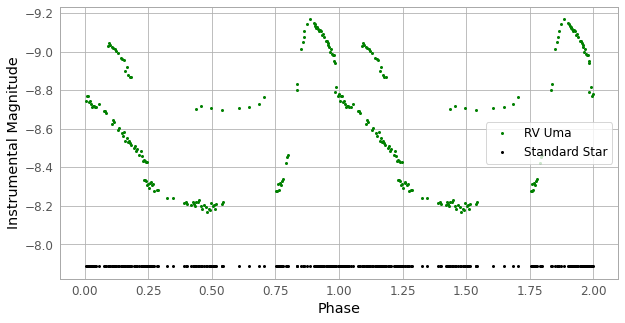

In [17]:
#Plots counts agasint time of
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

"""
#In flux
ax.plot(RV_Uma_df['Phase'], RV_Uma_df['Corrected Sum'], marker = 'o', markersize=2, color = 'blue', linestyle='none', label="RV Uma") 
ax.plot(RV_Uma_df['Phase']+1, RV_Uma_df['Corrected Sum'], marker = 'o', markersize=2, color = 'blue', linestyle='none') 

ax.plot(StandardStar_df['Phase'], StandardStar_df['Corrected Sum'], marker = 'o', markersize=2, color = 'black', linestyle='none', label="Standard Star") 
ax.plot(StandardStar_df['Phase']+1, StandardStar_df['Corrected Sum'], marker = 'o', markersize=2, color = 'black', linestyle='none') 
ax.set_ylabel('Flux')
"""

#In Instrumental Magnitude
ax.plot(RV_Uma_df['Phase'], RV_Uma_df['Correct Instrumental'], marker = 'o', markersize=2, color = 'green', linestyle='none', label="RV Uma") 
ax.plot(RV_Uma_df['Phase']+1, RV_Uma_df['Correct Instrumental'], marker = 'o', markersize=2, color = 'green', linestyle='none') 

ax.plot(StandardStar_df['Phase'], StandardStar_df['Correct instrumental'], marker = 'o', markersize=2, color = 'black', linestyle='none', label="Standard Star") 
ax.plot(StandardStar_df['Phase']+1, StandardStar_df['Correct instrumental'], marker = 'o', markersize=2, color = 'black', linestyle='none') 


ax.invert_yaxis()
ax.set_ylabel('Instrumental Magnitude')

ax.set_xlabel('Phase')

ax.legend()

In [13]:
RV_Uma_df.to_csv('RV_Uma.csv') # transforms df into a cvs file and saves it to computer
StandardStar_df.to_csv('StandardStar.csv')

#RV_Uma_df
#StandardStar_df

In [22]:
apparent_mag_green = 10.858340
offset = apparent_mag_green - Average_instrumental
RV_Uma_df['Apparent Magnitude'] = RV_Uma_df['Correct Instrumental'] + offset
RV_Uma_df

,File ID,x-pos,y-pos,Aperture Sum,Median Flux without bkg,Sum without bkg,Date and Time,Corrected Sum,Instrumental Magnitude,Correct Instrumental,Phase,Apparent Magnitude
0,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,1147.724316,899.292337,6570.794005,0.049101,2262.970904,2022-03-20 21:32:15,2043.396696,-8.275882,-8.275882,0.753997,10.468493
1,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,1148.051277,898.718520,6733.121157,0.054677,2280.234172,2022-03-20 21:34:34,2043.184653,-8.275769,-8.275769,0.757434,10.468606
2,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,1148.057799,898.682328,6921.914908,0.058283,2305.911397,2022-03-20 21:36:59,2114.802349,-8.313174,-8.313174,0.761020,10.431200
3,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,1148.676345,897.941623,7055.200459,0.043436,2291.978675,2022-03-20 21:39:18,2054.282344,-8.281650,-8.281650,0.764457,10.462725
4,..\RV Uma\2022_03_20\Green\Reduced_RV_Uma_Ligh...,1152.778211,912.045449,7213.868628,0.045560,2318.074839,2022-03-20 21:41:41,2127.257524,-8.319550,-8.319550,0.767993,10.424825
...,...,...,...,...,...,...,...,...,...,...,...,...
146,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,1157.239484,914.518117,12507.482455,0.053311,2432.207338,2023-04-03 22:12:31,3012.740285,-8.697404,-8.697404,0.538988,10.046971
147,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,1164.959941,936.920798,11345.962213,0.050722,2465.555075,2023-04-03 22:58:17,3039.534522,-8.707018,-8.707018,0.606891,10.037357
148,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,1165.100979,913.092806,10633.405720,0.045528,2465.710971,2023-04-03 23:25:35,3060.398454,-8.714445,-8.714445,0.647395,10.029930
149,..\RV Uma\2023_04_03\RV_UMa\Light\Green\Reduce...,1150.305577,918.570381,10526.918926,0.048486,2504.299530,2023-04-03 23:51:13,3097.004777,-8.727355,-8.727355,0.685426,10.017020


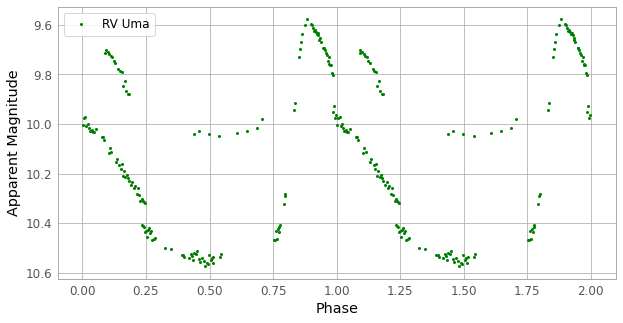

In [23]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

#In Instrumental Magnitude
ax.plot(RV_Uma_df['Phase'], RV_Uma_df['Apparent Magnitude'], marker = 'o', markersize=2, color = 'green', linestyle='none', label="RV Uma") 
ax.plot(RV_Uma_df['Phase']+1, RV_Uma_df['Apparent Magnitude'], marker = 'o', markersize=2, color = 'green', linestyle='none') 

#ax.plot(StandardStar_df['Phase'], StandardStar_df['Correct instrumental'], marker = 'o', markersize=2, color = 'black', linestyle='none', label="Standard Star") 
#ax.plot(StandardStar_df['Phase']+1, StandardStar_df['Correct instrumental'], marker = 'o', markersize=2, color = 'black', linestyle='none') 


ax.invert_yaxis()
ax.set_ylabel('Apparent Magnitude')

ax.set_xlabel('Phase')

ax.legend()

In [24]:
a = -0.97
b = -2.2

Magnitude = a + b*np.log10(Period)
Magnitude

-0.2446633622270168

In [25]:
d = ((apparent_mag_green + Magnitude) + 5)/5
distance = 10**d
distance

1326.5857490782162